## Importing the libraries.

In [88]:
import numpy as np # Linear Algebra, Transformations
# print(np.version)
import pandas as pd # Data processing, file reading

import warnings
warnings.filterwarnings("ignore")
# Memory monitoring
%load_ext memory_profiler 

# Data Visualisation assets
import matplotlib.pylab as plt
import plotly
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Keras environment for the LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation,Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

# ARIMA model environment
from statsmodels.tsa.arima_model import ARIMA
# from pmdarima.arima import auto_arima

# Evaulation
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Loading Stock Price train and test dataset

In [89]:
data = pd.read_csv('.\input\Data\Stocks\ibm.us.txt', sep=',', header=0).fillna(0)
data.head()
print('Total rows: {}'.format(len(data)))

Total rows: 14059


## Visualising train data

In [91]:
# data['date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

Total rows: 14059


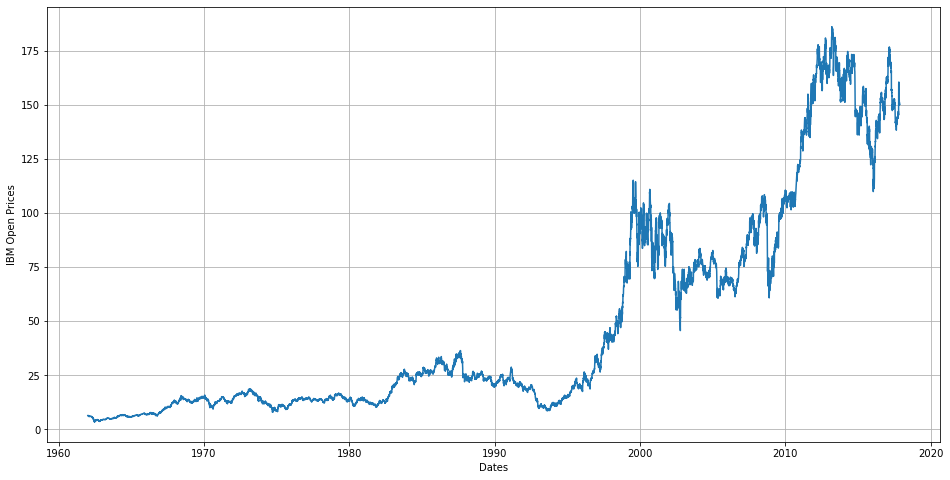

In [172]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d') # Date formatting for visualisation
data = pd.read_csv('.\input\Data\Stocks\ibm.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
# data = data.loc[:'2011-11-09'] # Cropping the data, alredy indexed last row
#Visualisation for IBM Stock Price between the first and 2006.11.10 sales
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('IBM Open Prices')
plt.plot(data['Open']);
print('Total rows: {}'.format(len(data)))

## Loading comparative dataset - IBM Stock

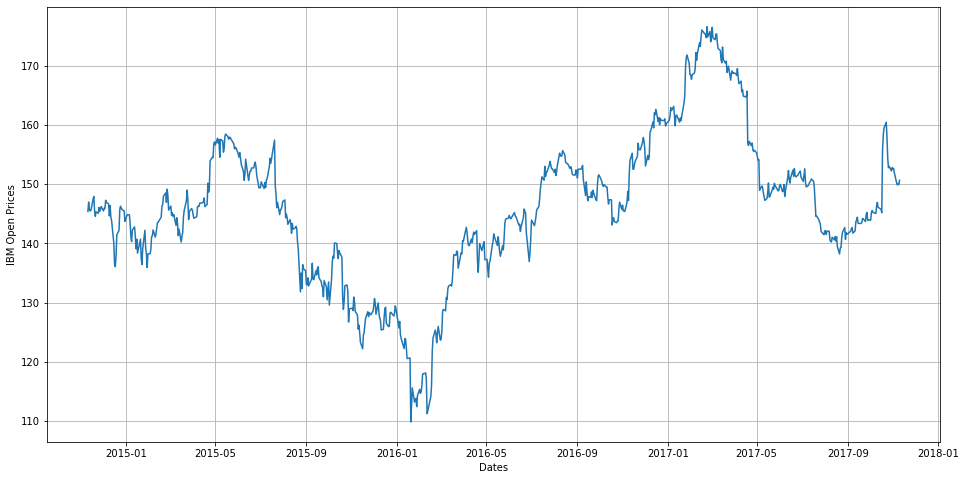

In [94]:
data_new = pd.read_csv('.\input\Data\Stocks\ibm.us.txt', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_new = data_new.loc['2014-11-10':] # Starts from 2006.11.10, IBM Stock Price
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('IBM Open Prices')
plt.plot(data_new['Open']);

## Plotting autocorrelation

##### Shows the size of the lag between the elements of the time series

No handles with labels found to put in legend.


         t-1      t+1
t-1  1.00000  0.96973
t+1  0.96973  1.00000


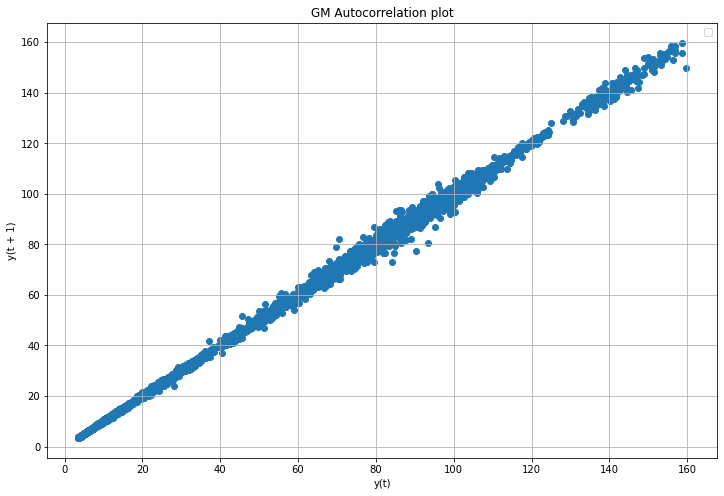

In [96]:
from pandas.plotting import lag_plot # Using pandas library
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=1)
plt.title('GM Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.018158
t+1  0.018158  1.000000


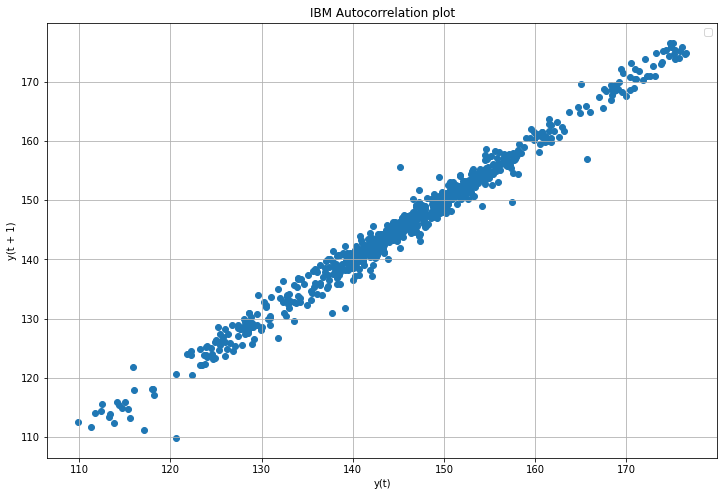

In [98]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data_new['Open'], lag=1)
plt.title('IBM Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data_new['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

## Splitting Data to Traind and Test data - GM

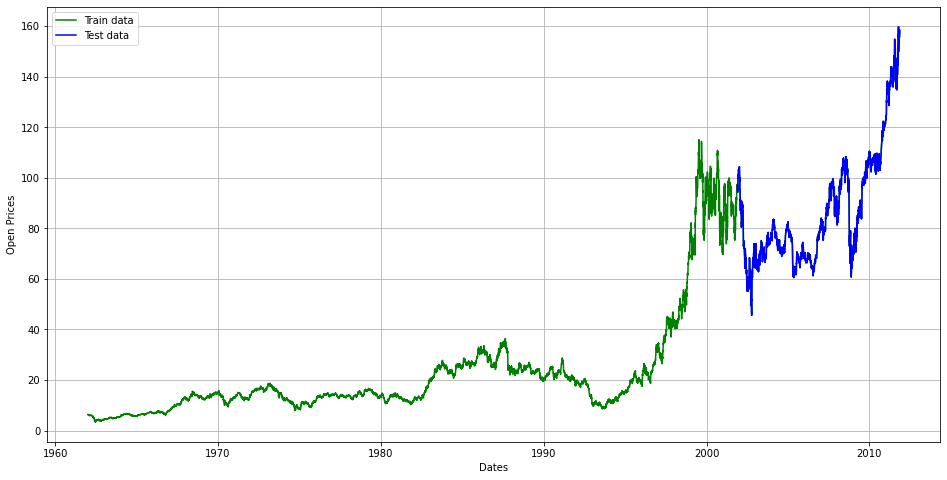

In [100]:
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):] # 80% Train data, 20% Test 
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

## ARIMA model by Bogdan Ivanyuk

#### Data examination

<Figure size 1152x576 with 0 Axes>

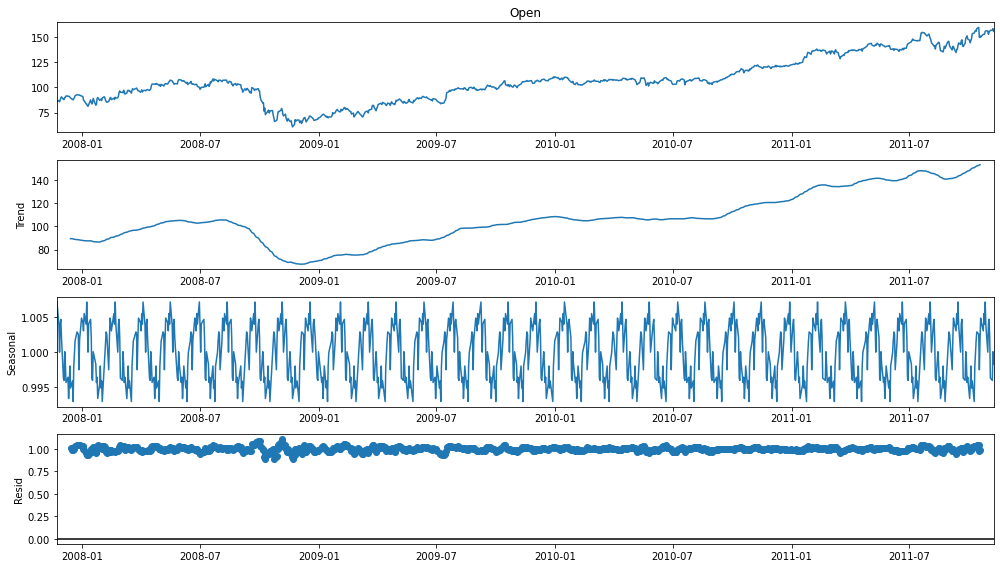

In [102]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
data_arima = data['Open']
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data_arima[-1000:], model='multiplicative', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

### In case if we want to find the best Order(p,d,q) parameters.
* p is the number of autoregressive terms, d is the number of nonseasonal differences needed for stationarity, and q is the number of lagged forecast errors in the prediction equation.

In [63]:
# from pyramid.arima import auto_arima
# model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
# print(model_autoARIMA.summary())
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()

## ARIMA Model Train and Predict

In [ ]:
%%time
%memit
# Monitoring performances

# Prepare datasets
train_arima = train_data['Open']
test_arima = test_data['Open']
warnings.filterwarnings("ignore")

history = [x for x in train_arima]
y = test_arima
# Make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))

model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# Rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # Invert transformed prediction
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)
# Report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))


peak memory: 423.88 MiB, increment: 0.00 MiB


## Visualise performance

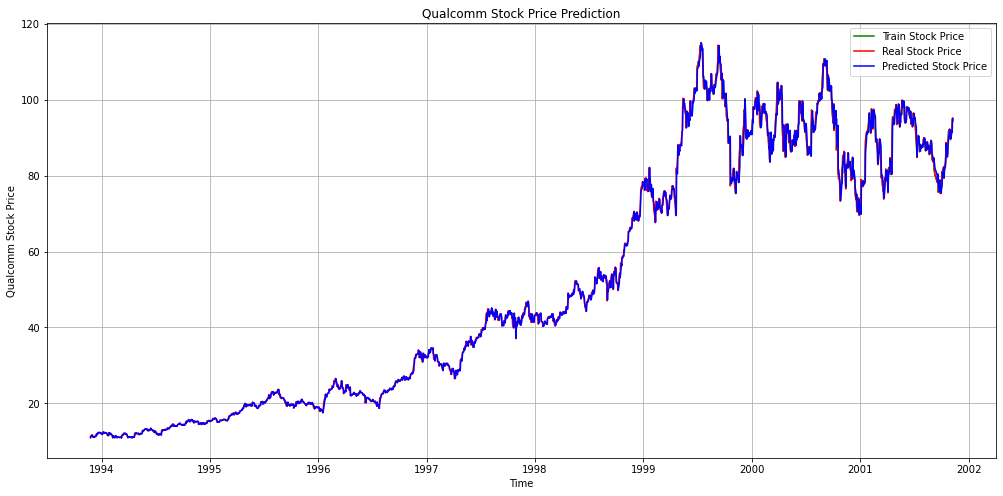

In [20]:
plt.figure(figsize=(17,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Qualcomm Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Qualcomm Stock Price')

plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

## Predicting on different Company markets - IBM Stock Market

In [22]:
%%time
%memit
# Monitor Performance

train_arima = train_data['Open']
test_arima = data_new['Open']
warnings.filterwarnings("ignore")

history = [x for x in train_arima]
y = test_arima

# Make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

# Rolling forecasts
for i in range(1, len(y)):
    # Predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # Invert transformed prediction
    predictions.append(yhat)
    # Observation
    obs = y[i]
    history.append(obs)
# Report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

peak memory: 295.65 MiB, increment: 0.01 MiB
MSE: 26.561422474253035
MAE: 1.3349053374114823
RMSE: 5.153777495609704
Wall time: 27.5 s


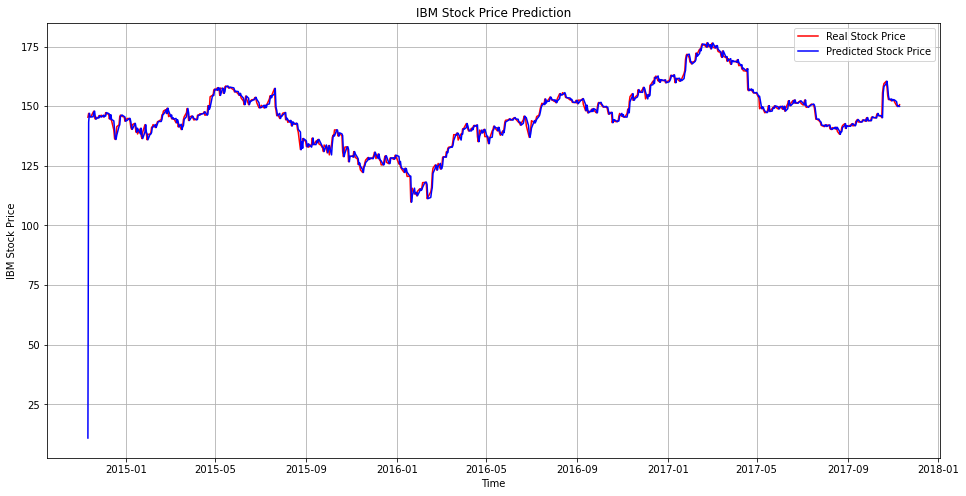

In [24]:
plt.figure(figsize=(16,8))
# plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(data_new.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(data_new.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')

plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()

# Preparing assets for Deep Learning Model

In [138]:
train = train_data.iloc[:, 0:1].values # Selecting open prices

## Feature Scaling

* The data for your sequence prediction problem probably needs to be scaled when training a neural network, such as a Long Short-Term Memory recurrent neural network.
* When a network is fit on unscaled data that has a range of values (e.g. quantities in the 10s to 100s) it is possible for large inputs to slow down the learning and convergence of your network and in some cases prevent the network from effectively learning your problem.

In [139]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

## Now we will creating a data structure with 30 timesteps and 1 output, i.e.Open Stock Price 

In [140]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # We take 30 previous prices
    y_train.append(train_scaled[i, 0]) # And 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

## Reshaping
* Here second argument is (batch_size, time_step ,input_dim)
* Batch_size is total number of stock price given by X_train.shape[0]
* Time_step is total number of previous stock price we want to consider while predicting present stock price given by X_train.shape[1]
*  Third argument is input_dim-in our case it is 1, i.e.Open price, but it can be more than one. It basically includes all those factors/indicators that can affect present stock price 

In [141]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

## Building the RNN

In [142]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.2,loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [143]:
%%time
%memit
# Initialise model architecture
nn_model = build_model(X_train, output_size=1, neurons = 32)
# Model output is next price normalised
# Train model on data
history = nn_model.fit(X_train, y_train, 
                            epochs=5, batch_size=8, verbose=2, shuffle=True)

peak memory: 457.59 MiB, increment: 0.07 MiB
Epoch 1/5
1254/1254 - 3s - loss: 0.0152
Epoch 2/5
1254/1254 - 3s - loss: 0.0101
Epoch 3/5
1254/1254 - 3s - loss: 0.0101
Epoch 4/5
1254/1254 - 3s - loss: 0.0100
Epoch 5/5
1254/1254 - 3s - loss: 0.0099
Wall time: 20.2 s


## Now making the predictions and visualising the results

In [145]:
# This will be used later while comparing and visualization for original Test data
real_stock_price = test_data.iloc[:,0:1].values # taking open price

# This will be used later while comparing and visualization for other Company
real_stock_price_other = data_new.iloc[:,0:1].values # taking open price

In [146]:
# Combine original train and test data vertically
# As previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# Our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [147]:
# Combine original train and test data vertically
# As previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on timesteps previous dates  
combine_other = pd.concat((train_data['Open'], data_new['Open']), axis = 0)
# Our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs_other = combine_other[len(combine_other) - len(data_new) - timesteps:].values
test_inputs_other = test_inputs_other.reshape(-1,1)
test_inputs_other = scaler.transform(test_inputs_other)

In [148]:
test_data.shape

(2510, 6)

In [149]:
data_new.shape

(758, 6)

In [150]:
#Ssame steps as we followed while processing training data for Original data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_test)
predicted_stock_price = nn_model.predict(X_test)
# Inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [151]:
# same steps as we followed while processing training data Other Company
X_test_other = []
for i in range(timesteps, data_new.shape[0]+timesteps):
    X_test_other.append(test_inputs_other[i-timesteps:i, 0])
X_test_other = np.array(X_test_other)
X_test_other = np.reshape(X_test_other, (X_test_other.shape[0], X_test_other.shape[1], 1))
predicted_stock_price_other = nn_model.predict(X_test_other)
# Inverse_transform because prediction is done on scaled inputs
predicted_stock_price_other = scaler.inverse_transform(predicted_stock_price_other)

## Visualising the results

In [152]:
# plt.plot(test_data.iloc[:,0:1].values, label = "actual")
# plt.plot(nn_model.predict(X_test), label = "predicted")
# plt.legend()
# plt.show()
# MAE = mean_absolute_error(test_data.iloc[:,0:1].values, nn_model.predict(X_test))
# print('The Mean Absolute Error is: {}'.format(MAE))

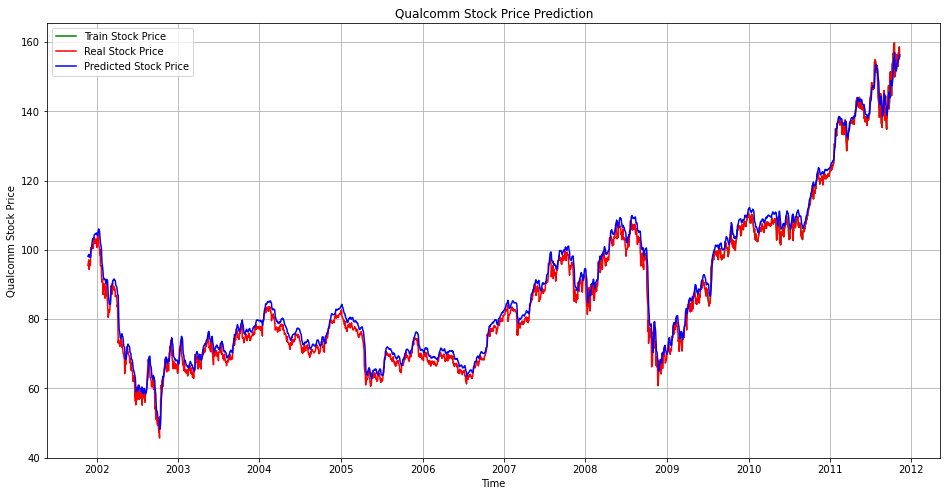

MSE: 6.641256038877459
MAE: 2.122691500234414
RMSE: 2.5770634526292633


In [153]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Qualcomm Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Qualcomm Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

## Different company - IBM Stock

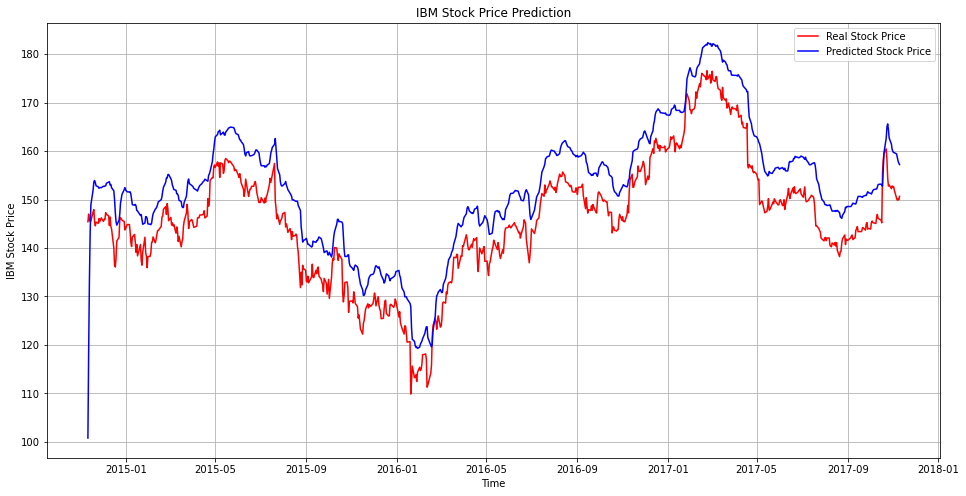

MSE: 55.20064644044098
MAE: 6.969615183405009
RMSE: 7.42971375225459


In [121]:
plt.figure(figsize=(16,8))
# plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(data_new.index, real_stock_price_other, color = 'red', label = 'Real Stock Price')
plt.plot(data_new.index, predicted_stock_price_other, color = 'blue', label = 'Predicted Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_31.pdf')
plt.show()

mse = mean_squared_error(real_stock_price_other, predicted_stock_price_other)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price_other, predicted_stock_price_other)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price_other, predicted_stock_price_other))
print('RMSE: '+str(rmse))

# Visualising further performance

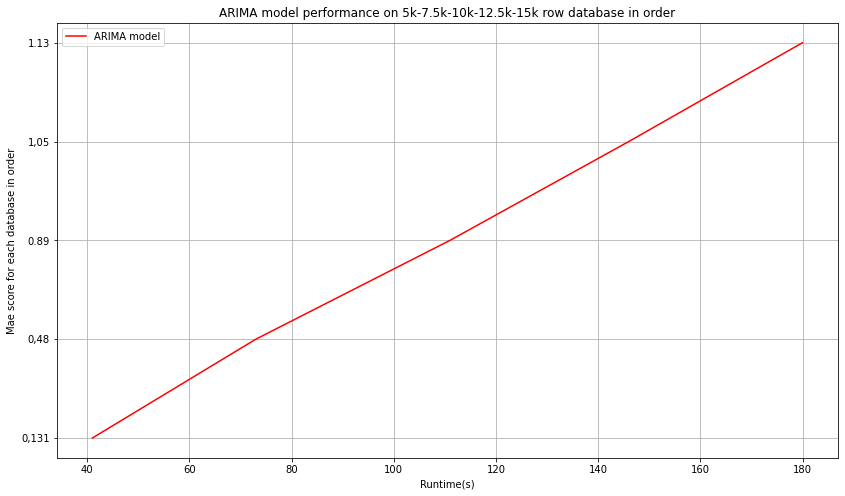

In [171]:
# data to be plotted
y = np.array(["0,131", "0,48", "0.89", "1,05", "1.13"]) 
x = np.array([41, 73, 111, 146, 180])

plt.plot(x, y, color ="red", label = "ARIMA model")
plt.legend()
plt.grid(True)

plt.title("ARIMA model performance on 5k-7.5k-10k-12.5k-15k row database in order") 
plt.xlabel("Runtime(s)") 
plt.ylabel("Mae score for each database in order")

plt.show()

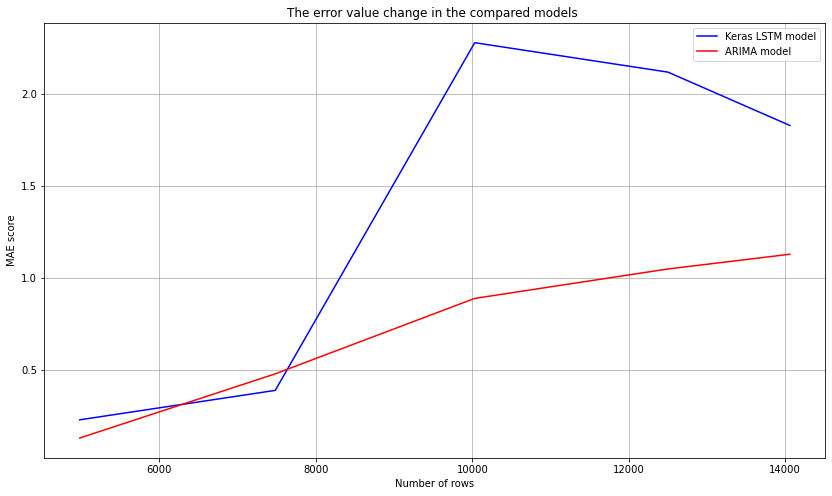

In [169]:
# data to be plotted
y = np.array([0.131, 0.48, 0.89, 1.05, 1.13])
z = np.array([0.23, 0.39, 2.28, 2.12, 1.83]) 
x = np.array([4980, 7480, 10030, 12500, 14059])

plt.plot(x, z, color ="blue", label = "Keras LSTM model" )
plt.plot(x, y, color ="red", label = "ARIMA model")
plt.legend()
plt.grid(True)

plt.title("The error value change in the compared models ") 
plt.xlabel("Number of rows") 
plt.ylabel("MAE score")

plt.show()

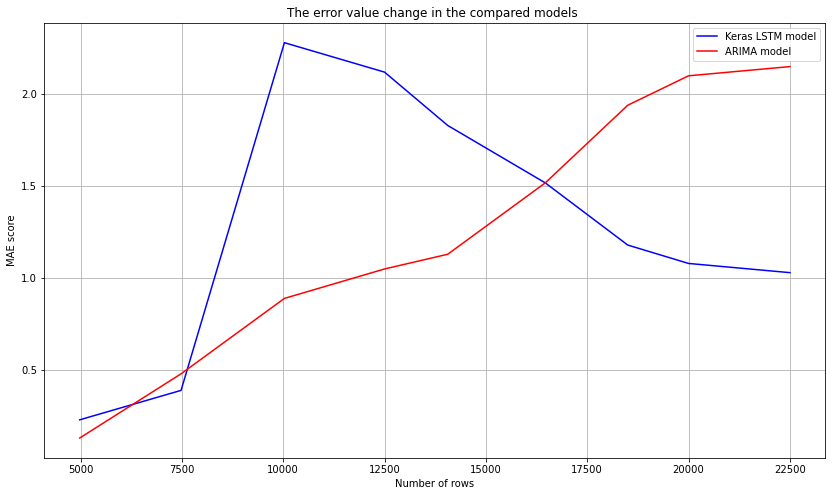

In [170]:
# data to be plotted
y = np.array([0.131, 0.48, 0.89, 1.05, 1.13, 1.518, 1.94, 2.1 , 2.15])
z = np.array([0.23, 0.39, 2.28, 2.12, 1.83, 1.518, 1.18, 1.08, 1.03]) 
x = np.array([4980, 7480, 10030, 12500, 14059 , 16465.2, 18500, 20000, 22500])

plt.plot(x, z, color ="blue", label = "Keras LSTM model" )
plt.plot(x, y, color ="red", label = "ARIMA model")
plt.legend()
plt.grid(True)

plt.title("The error value change in the compared models ") 
plt.xlabel("Number of rows") 
plt.ylabel("MAE score")

plt.show()